In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

C:\Users\zhaoj\AppData\Local\Temp\ipykernel_11308\2755429309.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


['station', 'measurement']

In [6]:
# View all of the classes that automap found

# Save references to each table
Base.classes.keys()


['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b5f2c0ab10>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
Measurement = Base.classes.measurement
session = Session(engine)

most_recent_date = session.query(func.max(Measurement.date)).first()

print(f"The most recent date is: {most_recent_date[0]}")

The most recent date is: 2017-08-23


<Figure size 1000x600 with 0 Axes>

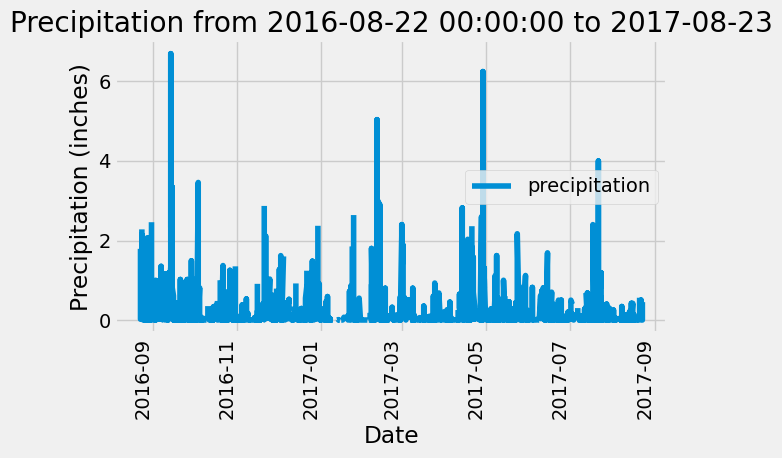

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores

one_year_ago = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d") - dt.timedelta(days=366)

data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()
df = pd.DataFrame(data, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title(f"Precipitation from {one_year_ago} to {most_recent_date[0]}")
plt.tight_layout()
plt.show()



In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
Station = Base.classes.station
total_stations = session.query(func.count(Station.station)).all()

print(f"Total number of stations: {total_stations[0][0]}")

Total number of stations: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
Measurement = Base.classes.measurement

# Query to find the most active stations
active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                          .group_by(Measurement.station)
                          .order_by(func.count(Measurement.station).desc())
                          .all())

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()

print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp:.2f}")

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


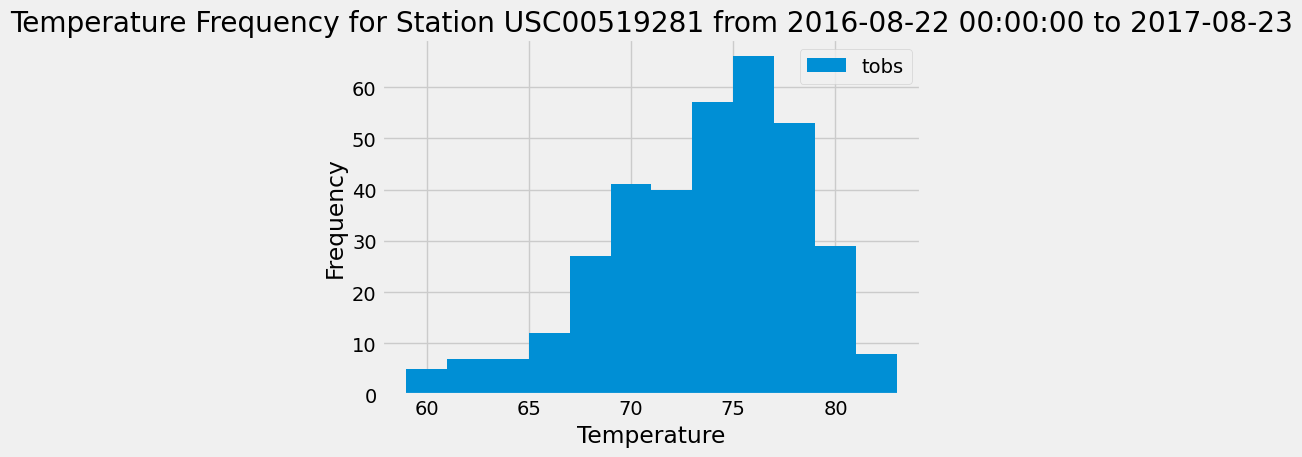

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = (session.query(Measurement.tobs)
                    .filter(Measurement.date >= one_year_ago)
                    .filter(Measurement.station == most_active_station)
                    .all())
temp_df = pd.DataFrame(temp_data, columns=['tobs'])
temp_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Temperature Frequency for Station {most_active_station} from {one_year_ago} to {most_recent_date[0]}")
plt.tight_layout()
plt.show()

# Close Session

In [18]:
# Close Session
session.close()